## My take on your analysis
This notebook illustrates some of my suggestions for how to structure your code.
I have tried to follow the principle of "Separation of Concerns", by making functions
that perform specialized jobs. That way it is easier to adapt and maintain.
The functions are located in the file called `functions`. I have tried to add some
documentation.

In [1]:
import pandas as pd
import seaborn as sns

from functions import graphTemplate, toLongForm, graphAllGrowthCurves, combineReplicates, graphCombinedGrowthCurves

## Defining a template
From what I can understand, all the important information and relationships
are stoded in your plate design. By using a template as the one below, the
code can be significantly simplified. How to combine the wells in order to
calculate means and standard deviations can be inferred from the well names.
I chose to use completely generic names to simplify the code a bit.

It will be significantly faster to adapt a template for your particular
plate design, than to go in and modify the code for each plate.

**Note**: The name '0' (i.e. zero) has a special meaning, and is interpreted
as blank samples.

The plate coordinates in the template are in this orientation:

```
    1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12
  ---------------------------------------------------
A |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
B |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
C |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
D |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
E |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
F |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
G |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
H |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
```

In [2]:
template = [
    [None, None, None, None, None, None, None, None, None, None, None, None],
    [None, '1', '1', '1', '7', '7', '7', '13', '13', '13', '19',       None],
    [None, '2', '2', '2', '8', '8', '8', '14', '14', '14', '19',       None],
    [None, '3', '3', '3', '9', '9', '9', '15', '15', '15', '19',       None],
    [None, '4', '4', '4', '10', '10', '10', '16', '16', '16', '20',    None],
    [None, '5', '5', '5', '11', '11', '11', '17', '17', '17', '20',    None],
    [None, '0', '0', '0', '12', '12', '12', '18', '18', '18', '20',    None],
    [None, None, None, None, None, None, None, None, None, None, None, None]
]

## Load and manipulate data
If I understood you correctly you have scripts that parse raw data files from the instruments, which results in the CSV file called `wideform.csv`.
Below I load this data file, convert it to long form, and finally combine the triplicates by calculating averages, standard deviations, and log transformations. 

Combining the replicates is based on identifying similar `Group` IDs defined in the template, and grouping them with matching `Time_hours` values.

**Note**: I am not doing anything about the cases where the triplicate measurements were identical (resulting in zero standard deviation and -infinite log transformations).

In [3]:
wideFormData = 'wideform.csv'
wideForm = pd.read_csv(wideFormData, delimiter=';')
longForm = toLongForm(wideForm, template)

combined = combineReplicates(longForm)
combined.to_csv('combined.csv')
# combined = pd.read_csv('combined.csv')

In [4]:
# The long form DataFrame looks like this
longForm.head()

,Time_hours,Well,Absorption,Row,Column,Group
0,0.00,B2,0.116,B,2,1
1,0.25,B2,0.121,B,2,1
2,0.50,B2,0.123,B,2,1
3,0.75,B2,0.126,B,2,1
4,1.00,B2,0.128,B,2,1


In [5]:
# The combined DataFrame looks like this
combined.head()

,Time_hours,n,Mean,StDev,Group,logMean,logStDevUpper,logStDevLower
0,0.00,3.0,0.117333,0.002517,0,-3.091315,-3.060699,-3.122595
1,0.25,3.0,0.121333,0.003055,0,-3.042952,-3.007076,-3.079743
2,0.50,3.0,0.123333,0.003055,0,-3.019365,-2.984064,-3.055552
3,0.75,3.0,0.126000,0.004000,0,-2.988504,-2.943416,-3.035047
4,1.00,3.0,0.129000,0.004000,0,-2.954557,-2.910502,-3.000000


## Visualizing the plate layout
The `graphTemplate` function  makes a Seaborn heatmap based on the groups defined in the template.

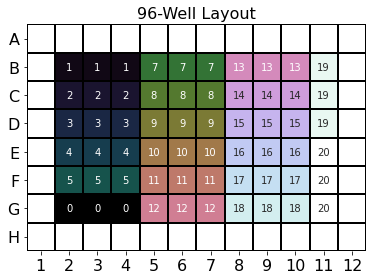

In [6]:
graphTemplate(template, savefig=False)

## Plotting all the growth curves
The `longForm` data frame contains growth curves from all wells. The `graphAllGrowthCurves` function plots all of these in a grid, and color codes the curves based on the `Group` they belong to.

This can serve as a quick check of what the curves look like.

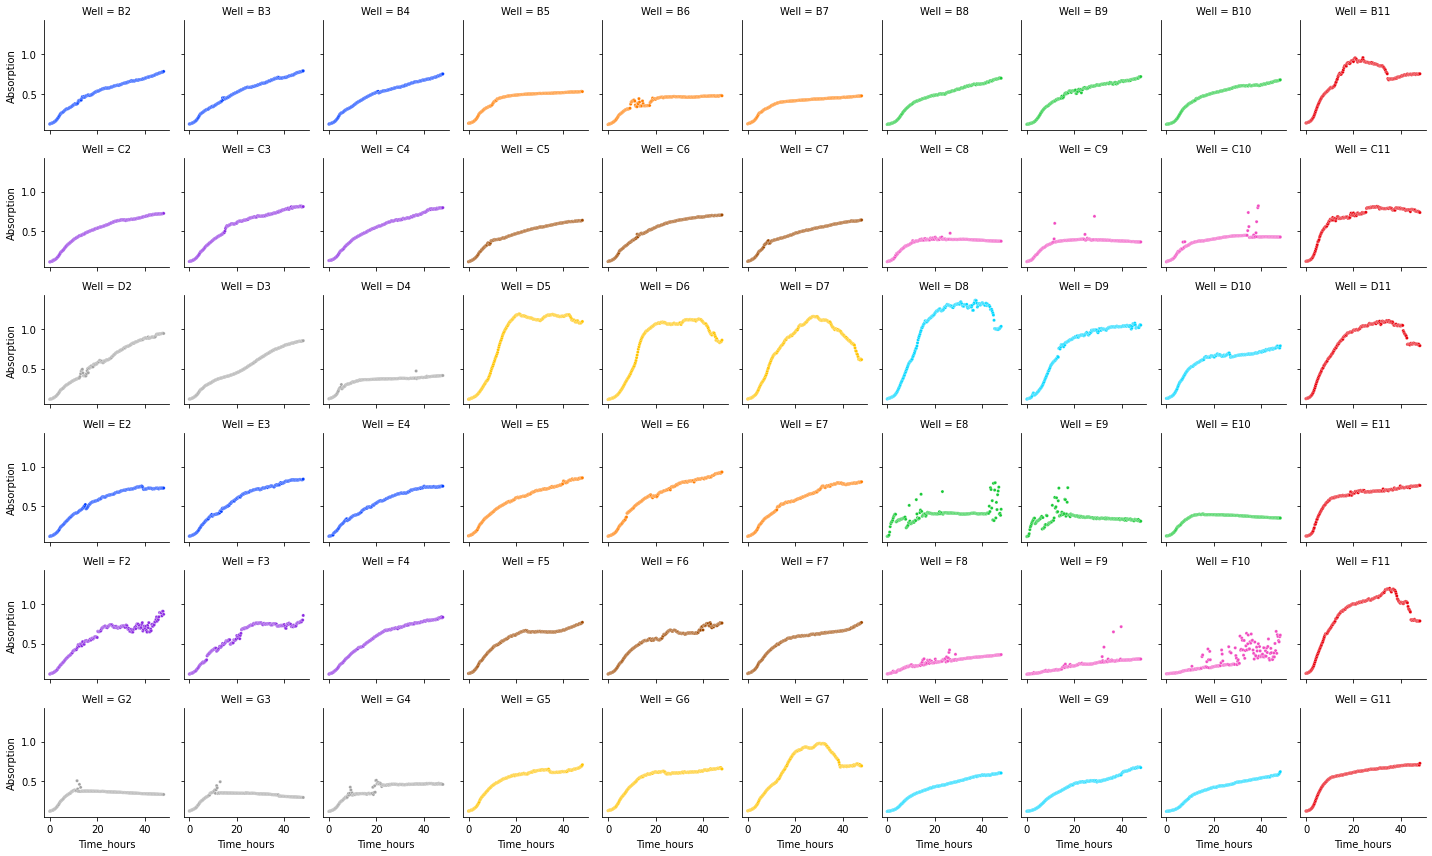

In [7]:
graphAllGrowthCurves(longForm, col_wrap=10, savefig=False)

## Plotting the average growth curves
The `graphCombinedGrowthCurves` function plots the average growth curves. 

By setting `augment=True`, the function also adds error bands based on the standard deviations (mean $\pm$ StDev) and overlays all the average curves with the average blank curves. 

By setting `log= True`, the function uses the log2 transformed averages and errors.

**Note**: I never subtracted the blanks from the averages (which you did in your code).

**Note**: Log transformed error boundaries were calculated like this:

$$
\mathrm{Upper} = \log_2 (\mathrm{Mean} + \mathrm{StDev})
$$

and

$$
\mathrm{Lower} = \log_2 (\mathrm{Mean} - \mathrm{StDev})
$$

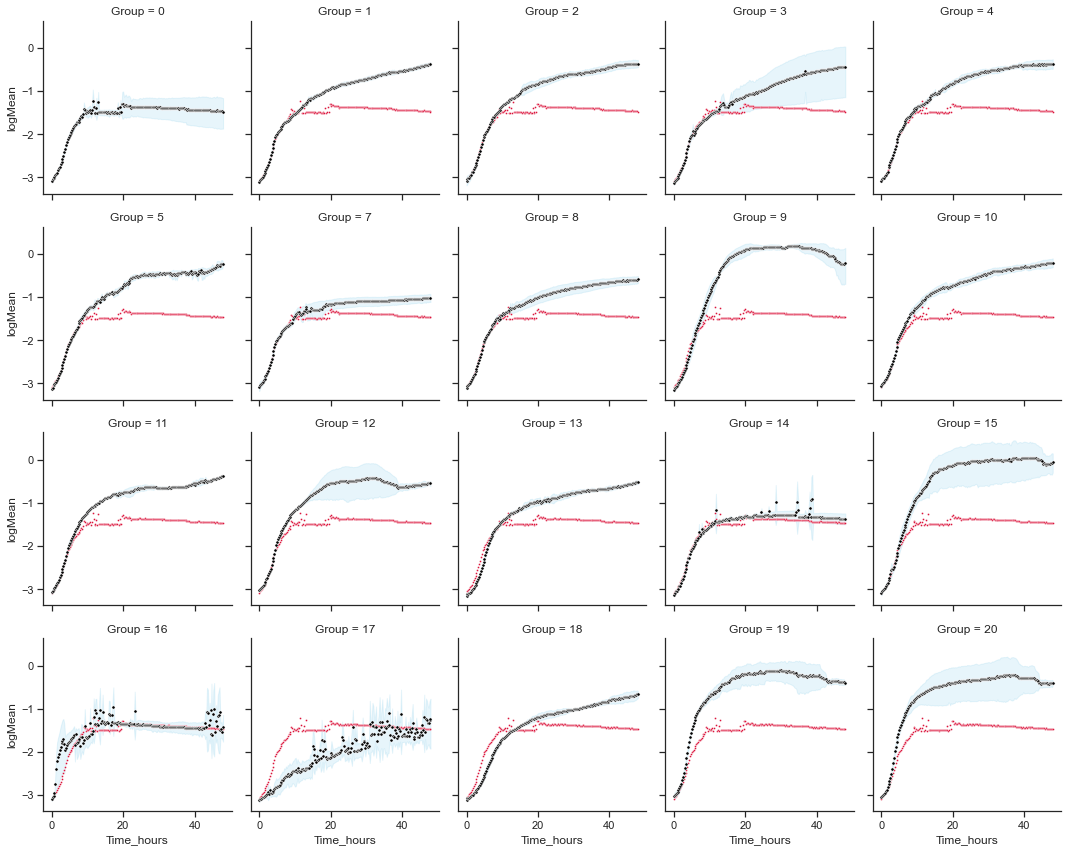

In [8]:
graphCombinedGrowthCurves(combined, col_wrap=5, log=True, augment=True, savefig=False)